
The REINFORCE Algorithm is one of the most Policy Gradient algorithms in renforcement learning
Policy gradient algorithms directly diffierintate the RL objective 
$$ J(\theta) = \mathop{\mathbb{E}}_{\pi_{\theta}}{[\sum_{t=1}^T}r(s_t,a_t)] $$
from the definitation of Expectation 
$$J(\theta) = \int \pi_\theta(a_t|s_t) \sum_{t=1}^Tr(s_t,a_t)  {d}(P(a_t|s_t) $$
This objective can be defferinated to be 
$$\nabla_\theta J(\theta) =\int \nabla_\theta \pi_\theta(a_t|s_t) \sum_{t=1}^Tr(s_t,a_t) {d}(P(a_t|s_t) $$
We know from calculus that 
$${d}\log{n} = \frac{{d}n}{n}$$
Hence the policy gradient is
$$\nabla_\theta J(\theta) =\int  \pi_\theta(a_t|s_t) \nabla_\theta \log {\pi_\theta(a_t|s_t)} \sum_{t=1}^Tr(s_t,a_t) {d}(P(a_t|s_t) $$
Which can be written as Expectation
$$\nabla_\theta J(\theta)  = \mathop{\mathbb{E}}_{\pi_{\theta}}[\nabla_\theta \log {\pi_\theta(a_t|s_t)}\sum_{t=1}^Tr(s_t,a_t)] $$

From a practicial point of view the general structre of any Reinfrocement learning algorithm is shown below
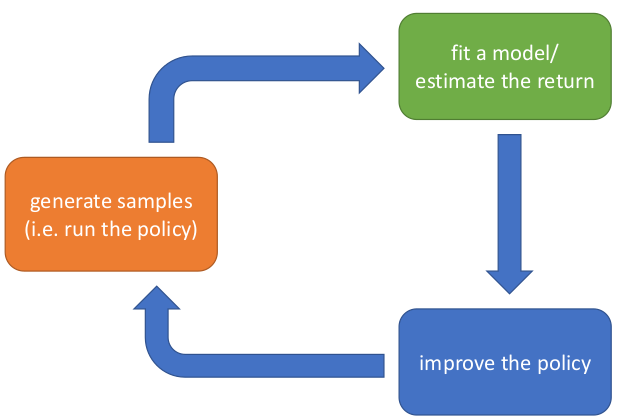
for this vareint of REINFORCE algorithms the strcure will be </br >  
1. Generate Data by running the most recent policy, specifically this step should return states, rewards, and actions for each batch of training episode
2. Return estimation will implement Monte Carlo policy evaluation with discount factos causality 
$$ \hat{Q}(s_t,a_t) = \sum_{{t'}=t}^T r(s_{t'},a_{t'})$$
3. In this step 

In [80]:
import gym
import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
import numpy as np

import numpy.random as random

from torch.utils.tensorboard import SummaryWriter

In [81]:
# create Network
class Policy_Network(nn.Module):
    def __init__(self):
        super(Policy_Network, self).__init__()
        
        self.fc1 = nn.Linear(in_features=2, out_features=128)
        # mean head
        self.mu = nn.Linear(in_features=128, out_features=1)
        # variance head
        self.var = nn.Linear(in_features=128, out_features=1)
        
        
    def forward(self, x):
        # shared layers
        # layer 1
        x = F.relu(self.fc1(x))
        
        
        
        return F.tanh(self.mu(x)), F.softplus(self.var(x))


In [82]:
# cartpole problem with discrete actions
# Network archetacture

class SampleGeneration():
    @staticmethod
    @torch.no_grad()
    def generate_samples(network, env='MountainCarContinuous-v0', N=4):
        states_N = []
        actions_N = []
        rewards_N = []
        
        env = gym.make(env)
        for trajectory in range(N):
            state = env.reset()
            states_N.append(state)
            rewards = []
            done = False
            while not done:
                state_t = torch.tensor(state.astype(np.float32)).unsqueeze(0)
                # forward pass to generate mu and var
                mu_t, var_t = network(state_t)
                mu = mu_t.detach().item()
                var = var_t.detach().item()
                std = np.sqrt(var)
                # sample an action from a normal distribution policy based on mu and var
                action = random.normal(mu, std)
                actions_N.append(action)
                state, reward, done, _ = env.step(np.array([action]))
                rewards.append(reward)
                if not done:
                    states_N.append(state)
            rewards_N.append(np.array(rewards))
            state_stack = np.stack(states_N)
        return (state_stack, rewards_N, np.array(actions_N))

In [83]:
def list_to_torch_tensor(List):
    l = []
    for element in List:
        for r in element:
            l.append(r)
    return torch.tensor(l, dtype=torch.float32)

In [84]:
class ReturnEstimator():
    # reward_to_go
    @staticmethod
    def estimate_return(rewards):
        gamma = 0.99
        res = [[] for i in range(len(rewards))]
        for i in range(len(rewards)):
            sum_r = 0.0
            for r in rewards[i]:
                sum_r *= gamma
                sum_r += r
                res[i].append(sum_r)
            res[i].reverse()
        return np.array(res)

In [85]:
def improve_policy(network, states, rewards_to_go, actions,optimizer, tb, step):
    
    optimizer.zero_grad()
    states_t = torch.tensor(states, dtype=torch.float32)
    q = list_to_torch_tensor(rewards_to_go)
    q_t = torch.tensor(q, dtype=torch.float32)
    actions_t = torch.tensor(actions, dtype=torch.float32)
    
    mu_t, var_t = network(states_t) # mean
    actions_log_probs_term1 = - (actions_t - mu_t)**2 / (2*var_t)
    actions_log_probs_term2 = - torch.log(torch.sqrt(2 * np.pi * var_t  ))
    actions_log_probs = actions_log_probs_term1 + actions_log_probs_term2
    weighted_actions_log_probs = actions_log_probs * q_t
    loss_entropy = - 0.0001 * (torch.log(2 * np.pi * var_t) + 1).mean()
    loss_policy = - weighted_actions_log_probs.mean()
    loss = loss_policy + loss_entropy
    tb.add_scalar('loss', loss, step)
    loss.backward()
    optimizer.step()

In [99]:
@torch.no_grad()
def test_policy(network, env="MountainCarContinuous-v0", render=False):
    runs = 5
    total_reward = 0.0
    env = gym.make(env)
    for run in range(runs):
        state = env.reset()
        done = False
        while not done:
            if render:
                env.render()
            state_t = torch.tensor(state, dtype=torch.float32)
            action,_ = network(state_t)
            state, reward, done, _ = env.step(action)
            total_reward += reward
    env.close()
    return total_reward / runs

In [89]:
# policy imporvment
# hyperparameters
seeds = [1,4,10,42]
episodes_num = 10000
N = 4
#######
env = 'MountainCarContinuous-v0'
rewards_100 = []
lrs = [0.001, 0.0001, 0.000005]
for lr in lrs:
    policy = Policy_Network()
    tb = SummaryWriter(comment=f"-env={env}, lr={lr}")
    states = torch.tensor(gym.make(env).reset(), dtype=torch.float32)
    tb.add_graph(policy, states)
    print(policy)
    optimizer = opt.Adam(policy.parameters(), lr=lr)
    for i in range(episodes_num):
        # run the policy
        states, rewards, actions = SampleGeneration.generate_samples(policy, N=N)
        # estimate the return
        q = ReturnEstimator.estimate_return(rewards)
        # imporove the polciy
        improve_policy(policy, states, q, actions, optimizer, tb, i )
        # test the policy
        test_reward = test_policy(policy)
        rewards_100.append(test_reward)
        tb.add_scalar('reward', test_reward, i)
        if len(rewards_100) >= 100:
            reward_100 = sum(rewards_100) / 100.0
            tb.add_scalar('reward_100', reward_100, i)
            rewards_100 = []
        for name, param in policy.named_parameters():
            if name!='logstd':
                tb.add_histogram(f'{name}', param, i)
                tb.add_histogram(f'{name}.grad', param.grad, i)
#                 tb.add_scalar(f'{name}.grad.mean', torch.mean(param.grad), i)
#                 tb.add_scalar(f'{name}.grad.max', torch.max(param.grad), i)

Policy_Network(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (mu): Linear(in_features=128, out_features=1, bias=True)
  (var): Linear(in_features=128, out_features=1, bias=True)
)


/home/faisal/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


KeyboardInterrupt: 

In [93]:
torch.save(policy.state_dict(),'/home/faisal/Documents/ML practice/Deep Learning/pytorch/REINFORCE_Continuous/polciy.pt')

In [101]:
test_policy(policy,render=True)

-2.6827130249027165